In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap
import copy

sns.set_style('ticks', {'font.family': 'FreeSans'})

master_dir = '../'

In [2]:
# Import GO summary
df_COVID = pd.read_excel(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/Monocyte/GO summary.xlsx',
                        sheet_name='COVID', header=12)
df_sepsis = pd.read_excel(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/Monocyte/GO summary.xlsx',
                        sheet_name='Sepsis', header=12)
df_HIV = pd.read_excel(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/Monocyte/GO summary.xlsx',
                        sheet_name='HIV', header=12)

In [3]:
df_COVID.head()

,GO biological process complete,Homo sapiens - REFLIST (20595),upload_1 (422),upload_1 (expected),upload_1 (over/under),upload_1 (fold Enrichment),upload_1 (raw P-value),upload_1 (FDR)
0,proteasome assembly (GO:0043248),14,4,0.29,+,13.94,3.920000e-04,0.038200
1,respiratory chain complex IV assembly (GO:0008...,26,5,0.53,+,9.39,3.520000e-04,0.035100
2,mitochondrial translational elongation (GO:007...,88,13,1.80,+,7.21,1.180000e-07,0.000050
3,mitochondrial translational termination (GO:00...,89,13,1.82,+,7.13,1.330000e-07,0.000055
4,translational termination (GO:0006415),97,13,1.99,+,6.54,3.260000e-07,0.000129


In [4]:
# Dataframe of interesting GO processes in COVID, vs. other diseases
df_COVID = df_COVID.add_prefix('COVID_')
#df_COVID = df_COVID[df_COVID['COVID_upload_1 (FDR)']<0.0001]
df_COVID = df_COVID[df_COVID['COVID_upload_1 (fold Enrichment)'] != ' < 0.01']
df_COVID = df_COVID[df_COVID['COVID_upload_1 (fold Enrichment)'].astype(float) > 5]
df_compare = df_COVID.loc[:, ['COVID_GO biological process complete', 'COVID_upload_1 (FDR)']].copy()

df_sepsis = df_sepsis.add_prefix('sepsis_')
df_compare = pd.merge(df_compare, 
                      df_sepsis.loc[:, ['sepsis_GO biological process complete', 'sepsis_upload_1 (FDR)']].copy(),
                      left_on='COVID_GO biological process complete', right_on='sepsis_GO biological process complete',
                      how='left')

df_HIV = df_HIV.add_prefix('HIV_')
df_compare = pd.merge(df_compare, 
                      df_HIV.loc[:, ['HIV_GO biological process complete', 'HIV_upload_1 (FDR)']].copy(),
                      left_on='COVID_GO biological process complete', right_on='HIV_GO biological process complete',
                      how='left')

#sns.heatmap(data=df_compare.loc[:, ['upload_1 (FDR)']], cmap='viridis', xticklabels=['COVID-19'])
            #yticklabels=df_compare['GO biological process complete'])

In [5]:
df_compare.head()

,COVID_GO biological process complete,COVID_upload_1 (FDR),sepsis_GO biological process complete,sepsis_upload_1 (FDR),HIV_GO biological process complete,HIV_upload_1 (FDR)
0,proteasome assembly (GO:0043248),0.038200,NaN,NaN,NaN,NaN
1,respiratory chain complex IV assembly (GO:0008...,0.035100,NaN,NaN,NaN,NaN
2,mitochondrial translational elongation (GO:007...,0.000050,NaN,NaN,NaN,NaN
3,mitochondrial translational termination (GO:00...,0.000055,NaN,NaN,NaN,NaN
4,translational termination (GO:0006415),0.000129,NaN,NaN,NaN,NaN


In [6]:
df_compare = df_compare.set_index('COVID_GO biological process complete')
df_compare = df_compare.drop(columns=['sepsis_GO biological process complete', 
                                      'HIV_GO biological process complete'])

Text(1158.0, 0.5, 'GO biological process complete')

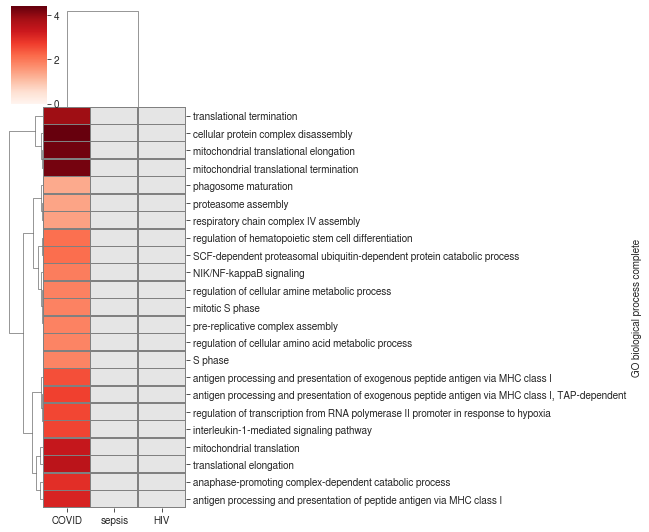

In [7]:
cmap = copy.copy(cm.get_cmap('Reds'))
newcolors = cmap(np.linspace(0, 1, 256))[::1]
gray = np.array([128/256, 128/256, 128/256, 0.2]) # NaNs will be filled to have p value of 1, which will then
# have a gray color on the clustermap
newcolors[:1, :] = gray
newcmap = ListedColormap(newcolors)
fig = sns.clustermap(-np.log10(df_compare.fillna(1)), cmap=newcmap, figsize=(10, 7.5), lw=0.5, linecolor='gray')
fig.ax_heatmap.set_yticklabels([str(x).split('\'')[-2].split('(')[0] for x in fig.ax_heatmap.get_yticklabels()])
fig.ax_heatmap.set_xticklabels([str(x).split('\'')[-2].split('_')[0] for x in fig.ax_heatmap.get_xticklabels()])
fig.ax_heatmap.set_ylabel('GO biological process complete')
#plt.savefig(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/Monocyte/GO_COVID_vs_rest.pdf')

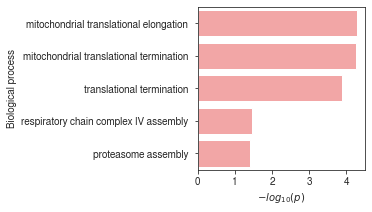

In [71]:
# Shorter summary version
temp = df_COVID[df_COVID['COVID_upload_1 (fold Enrichment)'] > 5].copy()
temp = temp.sort_values('COVID_upload_1 (fold Enrichment)', ascending=False).iloc[:5].sort_values('COVID_upload_1 (FDR)')

plt.figure(figsize=[3, 3])
simplified_processes = [x.split('(')[0].split(',')[0] for x in temp['COVID_GO biological process complete']]
g = sns.barplot(x=-np.log10(temp['COVID_upload_1 (FDR)']),
           y=simplified_processes, color='#ff9999')
plt.ylabel('Biological process')
plt.xlabel(r'$-log_{10}(\it{p})$')
plt.savefig(master_dir + 'output/disease_comparisons/gex_high_vs_non-PE/Monocyte/GO_COVID_unique_summary.pdf')